In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import keras.backend as K
# import xgboost as xgb
import os

from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model  
from keras.layers.core import Dense, Activation  
from keras.layers import Input, Dense, LSTM, Flatten, Dropout, Reshape,\
                         Conv1D, MaxPooling1D, Convolution1D,\
                         Convolution2D, MaxPooling2D,\
                         Convolution3D, MaxPooling3D
from keras.models import Sequential
# from keras.layers import Input, Dense, LSTM, Flatten, Reshape
from keras.models import Model
from keras.preprocessing import sequence
# from keras.optimizers import Nadam
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping


%matplotlib inline

In [18]:
data_dir = '../data2/PekerisSim15dB'

X_training = np.load(os.path.join(data_dir, "X_train.p"))#"../data2/X_train_f100.npy")
Y_training = np.load(os.path.join(data_dir, "Y_train.p"))#"../data2/Y_train_f100.npy")

X_val = np.load(os.path.join(data_dir, "X_val.p"))#"../data2/X_val_f100.npy")
Y_val = np.load(os.path.join(data_dir, "Y_val.p"))#"../data2/Y_val_f100.npy")

X_testing = np.load(os.path.join(data_dir, "X_test.p"))#"../data2/X_test_f100.npy")
Y_testing = np.load(os.path.join(data_dir, "Y_test.p"))#"../data2/Y_test_f100.npy")

X_training = np.concatenate( (X_training, X_val), axis=0 )
Y_training = np.concatenate( (Y_training, Y_val), axis=0 )

# Centering and Normalizing data
mux = np.mean(X_training, axis=0)
stdx = np.std(X_training, axis=0)
X_training = (X_training - mux)/stdx
X_val = (X_val - mux)/stdx
X_testing = (X_testing - mux)/stdx

In [4]:
data_dir = '../data2/5dBsim'

X_training = np.load(os.path.join(data_dir, "X_train.npy"))#"../data2/X_train_f100.npy")
Y_training = np.load(os.path.join(data_dir, "Y_train.npy"))#"../data2/Y_train_f100.npy")

X_val = np.load(os.path.join(data_dir, "X_val.npy"))#"../data2/X_val_f100.npy")
Y_val = np.load(os.path.join(data_dir, "Y_val.npy"))#"../data2/Y_val_f100.npy")

X_testing = np.load(os.path.join(data_dir, "X_test.npy"))#"../data2/X_test_f100.npy")
Y_testing = np.load(os.path.join(data_dir, "Y_test.npy"))#"../data2/Y_test_f100.npy")

# Centering and Normalizing data
mux = np.mean(X_training, axis=0)
stdx = np.std(X_training, axis=0)
X_training = (X_training - mux)/stdx
X_val = (X_val - mux)/stdx
X_testing = (X_testing - mux)/stdx

In [26]:
def get_model(data_dim, time_steps):
    nb_filters = 200
    
    ip_shape = (time_steps, data_dim[0], data_dim[1], data_dim[2])
    inputs = Input(shape = ip_shape)
    conv_1 = Convolution3D(filters = 256, kernel_size = (1,5,1),
                    activation='tanh', name="Conv1")(inputs)
#     maxpool_1 = MaxPooling3D(pool_size=(1,3,1), padding="valid", name="maxpool1")(conv_1)
#     batch_norm1 = BatchNormalization( name = "batch_norm_1")(maxpool_1)
    conv_2 = Convolution3D(filters = 128, kernel_size = (1,3,1), 
                     activation='relu', name="Conv2")(conv_1)
#     maxpool_2 = MaxPooling3D(pool_size=(1,3,1), padding="valid", name="maxpool2")(conv_2)
#     batch_norm2 = BatchNormalization( name = "batch_norm_2")(maxpool_2)
    
    conv_3 = Convolution3D(filters = 1, kernel_size = (1,3,1), 
                     activation='relu', name="Conv3")(conv_2)
    maxpool_3 = MaxPooling3D(pool_size=(1,3,1), padding="valid", name="maxpool3")(conv_3)
#     batch_norm2 = BatchNormalization( name = "batch_norm_2")(maxpool_2)
    layer_shape = maxpool_3._keras_shape
    maxpool_3 = Reshape(target_shape=(layer_shape[1], layer_shape[2]*layer_shape[3]*layer_shape[4]),
                        name="maxpool3_RS")(maxpool_3)
    
    flatten = Flatten()(maxpool_3)
    
    lstm_1 = LSTM(128, return_sequences=False, name="lstm_1")(maxpool_3)
#     lstm_2 = LSTM(128, return_sequences="True", name="lstm_2")(lstm_1)
    
    
#     dense_1 = Dense(1024, activation='relu', name="Dense1")(flatten)
#     dropout_1 = Dropout(0.2)(dense_1)
#     dense_2 = Dense(512, activation='relu', name="Dense2")(dense_1)
#     dropout_1 = Dropout(0.2)(dense_2)
    output = Dense(1, name="output")(flatten)
    model = Model(inputs = inputs, output = output)
    
    return model

In [6]:
def create_dataset(X, Y, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(X)-time_steps-1):
        a = X[i:(i+time_steps)]
        dataX.append(a)
        a = Y[(i+time_steps)]
        dataY.append(a)  #dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
time_steps = 20
trainX, trainY = create_dataset(X_training, Y_training, time_steps)
valX, valY = create_dataset(X_val, Y_val, time_steps)
testX, testY = create_dataset(X_testing, Y_testing, time_steps)

In [20]:
print(X_training.shape, Y_training.shape)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)
print(valX.shape, valY.shape)

(3000, 16, 51, 2) (3000,)
(2979, 20, 16, 51, 2) (2979,)
(1479, 20, 16, 51, 2) (1479,)
(1479, 20, 16, 51, 2) (1479,)


In [27]:
n_epochs = 50
data_dim = (X_training.shape[1], X_training.shape[2], 2)
print(data_dim)
batch_size = 1
L=len(X_training)
n_Iter = int(L/batch_size)

optimizer = optimizers.Adadelta()#, beta_1=0.9, beta_2=0.999, epsilon=1e-08)#, schedule_decay=0.004)
model = get_model(data_dim, time_steps)
model.compile(loss="mean_squared_error", optimizer=optimizer)
model.summary()
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4,
                          verbose=1, mode='auto')
callbacks_list = [earlystop]
# val_data = (np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1)), Y_val)
# Y_train = np.reshape( Y_training, (L, 1, 1) )
# X_train = np.reshape( X_training, (L, X_training.shape[1], 1) )

(16, 51, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 20, 16, 51, 2)     0         
_________________________________________________________________
Conv1 (Conv3D)               (None, 20, 12, 51, 256)   2816      
_________________________________________________________________
Conv2 (Conv3D)               (None, 20, 10, 51, 128)   98432     
_________________________________________________________________
Conv3 (Conv3D)               (None, 20, 8, 51, 1)      385       
_________________________________________________________________
maxpool3 (MaxPooling3D)      (None, 20, 2, 51, 1)      0         
_________________________________________________________________
maxpool3_RS (Reshape)        (None, 20, 102)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2040)              0        

C:\Users\aksha\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [28]:
model.fit(x=trainX, y=trainY, batch_size=batch_size, epochs=n_epochs, 
          validation_split=0.3,
#           validation_data=(X_testing, Y_testing), 
          callbacks=callbacks_list)

Train on 2085 samples, validate on 894 samples
Epoch 1/50
2085/2085 [==============================] - 47s 23ms/step - loss: 5.0841 - val_loss: 0.5563
Epoch 2/50
2085/2085 [==============================] - 46s 22ms/step - loss: 1.1071 - val_loss: 0.0758
Epoch 3/50
2085/2085 [==============================] - 46s 22ms/step - loss: 0.8099 - val_loss: 0.3382
Epoch 4/50
2085/2085 [==============================] - 46s 22ms/step - loss: 0.6785 - val_loss: 0.0938
Epoch 5/50
2085/2085 [==============================] - 46s 22ms/step - loss: 0.5536 - val_loss: 0.0505
Epoch 6/50
2085/2085 [==============================] - 46s 22ms/step - loss: 0.5048 - val_loss: 0.9599
Epoch 7/50
2085/2085 [==============================] - 46s 22ms/step - loss: 0.4391 - val_loss: 0.1305
Epoch 8/50
2085/2085 [==============================] - 47s 22ms/step - loss: 0.3892 - val_loss: 0.1064
Epoch 9/50
2085/2085 [==============================] - 47s 22ms/step - loss: 0.3847 - val_loss: 0.1014
Epoch 00009: earl

In [ ]:
# # Save model
# model.save('model_1D_CNN.h5')

# Load saved model
# model = load_model('model_mlp_time_data.h5')

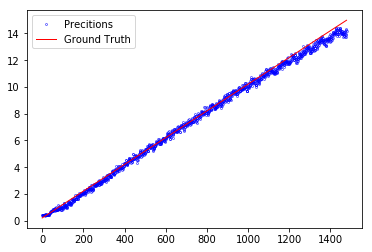

Test RMSE: 0.26794428087849287


In [29]:
# 100 components, full data, n_estimators = 100, reg:gamma
# preds = model.predict(np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1)))
# rmse = np.sqrt(mean_squared_error(preds, Y_val)) #np.sqrt(np.mean((preds-Y_testing)**2))
# print("Val RMSE:", rmse)

preds = model.predict(testX)#np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1)))
plt.plot(preds,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(testY,'r',linewidth=1.0)
plt.legend(['Precitions', 'Ground Truth'])
plt.show()

rmse = np.sqrt(mean_squared_error(preds, testY)) #np.sqrt(np.mean((preds-Y_testing)**2))
print("Test RMSE:", rmse)